In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline
import seaborn as sns

加载数据集

In [2]:
X,y = datasets.make_moons(n_samples=500,noise=0.3,random_state=42)

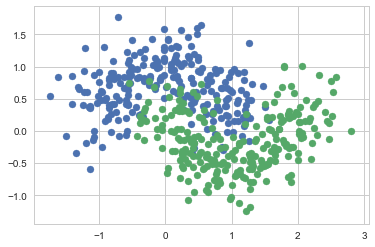

In [3]:
sns.set(style="whitegrid")
plt.scatter(X[y==0,0],X[y==0,1])
plt.scatter(X[y==1,0],X[y==1,1])

# 推导集成学习

In [4]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

逻辑回归训练

In [5]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
log_clf.fit(X_train,y_train)
log_clf.score(X_test,y_test)

0.864

SVM训练

In [6]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.score(X_test,y_test)

0.888

使用决策树

In [15]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=666)
dt_clf.fit(X_train,y_train)
dt_clf.score(X_test,y_test)

0.864

3组模型进行预测

In [16]:
y_predict1 = log_clf.predict(X_test)
y_predict2 = svm_clf.predict(X_test)
y_predict3 = dt_clf.predict(X_test)

In [17]:
y_predict = np.array((y_predict1+y_predict2+y_predict3)>2,dtype=int)

In [18]:
y_predict[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_predict)

0.84

# 使用Hard Voting Classifier

In [20]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('log_clf',LogisticRegression()),
    ('svm_clf',SVC()),
    ('dt_clf',DecisionTreeClassifier(random_state=666))
], voting = 'hard')

In [21]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('log_clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('svm_clf...       min_weight_fraction_leaf=0.0, presort=False, random_state=666,
            splitter='best'))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [22]:
voting_clf.score(X_test,y_test)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.896

# Soft Voting Classifier

很多时候少数服从多数是不合理的，应该有权值的

将分类概率的作为权值

要求集合的每一个模型都能估计概率

In [24]:
voting_clf2 = VotingClassifier(estimators=[
    ('log_clf',LogisticRegression()),
    ('svm_clf',SVC(probability=True)),
    ('dt_clf',DecisionTreeClassifier(random_state=666))
], voting = 'soft')

In [26]:
voting_clf2.fit(X_train,y_train)
voting_clf2.score(X_test,y_test)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.912

# 创建更多的子模型，集成更多的子模型
子模型之间不能一直，要有差异性

每个子模型只看样本数据的一部分

例： 一共500个样本，每个子模型只看100个样本数据

每个子模型不需要太高的正确率

## 取样方式

放回取样 Bagging ，不放回取样 Pasting

统计学中，放回取样  ：bootstrap

# 使用Bagging

In [39]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500,max_samples=100,
                                bootstrap=True)

In [40]:
bagging_clf.fit(X_train,y_train)
bagging_clf.score(X_test,y_test)

0.912

In [41]:
bagging_clf2 = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=5000,max_samples=100,
                                bootstrap=True)
bagging_clf.fit(X_train,y_train)
bagging_clf.score(X_test,y_test)

0.912

# OOB  Out of Bag

有37%的样本没有被取到$\left (1 + \frac{1}{m}  \right )^{m}= \frac{1}{e}\approx 0.37$
使用测试数据集，使用这部分没有被取到的样本

In [56]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=5000,max_samples=100,
                                bootstrap=True,oob_score=True)
bagging_clf.fit(X,y)

Wall time: 7.36 s


In [48]:
bagging_clf.oob_score_

0.92

Bagging 的思路极易进行并行化处理  n_jobs

## n_jobs  调用多个核心

In [57]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=5000,max_samples=100,
                                bootstrap=True,oob_score=True,
                               n_jobs=-1)
bagging_clf.fit(X,y)

Wall time: 6.68 s


# Baggging 更多随机化  

针对特征进行随机采样  Random Subspaces     
即针对样本，又针对特征进行随机采样 Random patches; 即在行上选，又在列上选，就像是补丁一样

### bootstrap_features

max_features 对特征进行随机取样

In [63]:
random_subspaces_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500,max_samples=500,
                                bootstrap=True,oob_score=True,
                               n_jobs=-1,
                               max_features =1,bootstrap_features=True)
random_subspaces_clf.fit(X,y)
random_subspaces_clf.oob_score_

0.84

# 随机森林

Base Estimator: Decision Tree

决策树在节点划分上，在随机的特征子集上寻找最优划分特征

In [67]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, random_state=666,
                               oob_score=True,n_jobs=-1)
rf_clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=666, verbose=0, warm_start=False)

In [68]:
rf_clf.oob_score_

0.896

In [70]:
rf_clf2 = RandomForestClassifier(n_estimators=500, random_state=666,
                               oob_score=True,n_jobs=-1,
                                max_leaf_nodes = 16)
rf_clf2.fit(X,y)
rf_clf2.oob_score_

0.92

### Extra-Trees

决策树在节点划分上，使用随机的特征和随机的阈值(更快的速度)

提供额外的随机性，抑制了过拟合，但增大了bias



In [73]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators=500, bootstrap=True,oob_score = True,
                             random_state =666)
et_clf.fit(X,y)
et_clf.oob_score_

0.892

## 集成学习解决回归问题

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Boosting

每个模型都在尝试增强(Boosting)整体的效果



## Ada Boosting

In [78]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=500)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=500, random_state=None)

In [79]:
ada_clf.score(X_test,y_test)

0.856

# Gradient Boosting

In [82]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(max_depth =2, n_estimators=30)
gb_clf.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [83]:
gb_clf.score(X_test,y_test)

0.912

### Boosting 解决回归问题

加载相应的回归类的就可以了

# Stacking